In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))])
 
trainset = torchvision.datasets.MNIST(root='./data',download=True,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
 
testset = torchvision.datasets.MNIST(root='./data',download=True,train=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

In [0]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
 
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [0]:
def imshow(img):
  plt.imshow(img.numpy().squeeze(),cmap="gray")

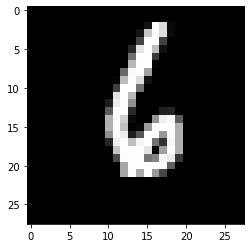

In [0]:
imshow(images[0]);

###CNN Model Architecture



In [0]:
import torch.nn as nn
from torch.nn import functional
import torch.optim as optim
import time
from IPython import display

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.C1=nn.Conv2d(1,32,kernel_size=(3,3))
    self.C2=nn.Conv2d(32,64,kernel_size=(3,3))
    self.S3=nn.MaxPool2d(kernel_size=(2,2),stride=2)
    self.D4=nn.Dropout(0.25)
    self.F5=nn.Linear(9216,128)
    self.D6=nn.Dropout(0.5)
    self.F7=nn.Linear(128,10)
    self.OL=nn.LogSoftmax(dim=1)
 
  def forward(self,x):
    x=torch.relu(self.C1(x))
    x=torch.relu(self.C2(x))
    x=self.S3(x)
    x=self.D4(x)
    x=x.view(x.size(0),-1)
    x=torch.relu(self.F5(x))
    x=self.D6(x)
    x=self.F7(x)
    x=self.OL(x)
 
    return x
 
    
net=Net()
print(net)

Net(
  (C1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (C2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (S3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (D4): Dropout(p=0.25, inplace=False)
  (F5): Linear(in_features=9216, out_features=128, bias=True)
  (D6): Dropout(p=0.5, inplace=False)
  (F7): Linear(in_features=128, out_features=10, bias=True)
  (OL): LogSoftmax()
)


In [0]:
net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (C1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (C2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (S3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (D4): Dropout(p=0.25, inplace=False)
    (F5): Linear(in_features=9216, out_features=128, bias=True)
    (D6): Dropout(p=0.5, inplace=False)
    (F7): Linear(in_features=128, out_features=10, bias=True)
    (OL): LogSoftmax()
  )
)

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

In [0]:

batch_size = 64
nepoch = 15;                    # number of epochs through training set
disp_freq = 100                 # display frequency

errs = []
losses = []

t_start=time.time()

for e in range(nepoch):
  
    running_loss = 0
    for images, labels in trainloader:
      ntrain=images.shape[0]
      images=images.to(device)
      labels=labels.to(device)
      for t in range(int(ntrain / batch_size)):

        
        # Training pass
        optimizer.zero_grad()
        
        #Model Evaluation and Log-loss evaluation
        output = net(images)
        loss = criterion(output, labels)

        
        #Backpopagating losses
        loss.backward()
        
        #Updating weights
        optimizer.step()

        
        pred = torch.argmax(torch.exp(output), dim=1)
        err = torch.mean((pred != labels).float())
        errs.append(err.cpu().detach().numpy())
        losses.append(loss.cpu().detach().numpy())

        
      running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time.time()-t_start)/60)


Epoch 0 - Training loss: 0.21795294446143895
Epoch 1 - Training loss: 0.08501245943642756
Epoch 2 - Training loss: 0.0666886960356824
Epoch 3 - Training loss: 0.05455543037686648
Epoch 4 - Training loss: 0.044929745382686924
Epoch 5 - Training loss: 0.04205742539929302
Epoch 6 - Training loss: 0.03710671577221358
Epoch 7 - Training loss: 0.03193134814103656
Epoch 8 - Training loss: 0.03131200449823189
Epoch 9 - Training loss: 0.026507148125977403
Epoch 10 - Training loss: 0.025570759998519283
Epoch 11 - Training loss: 0.024354679363050948
Epoch 12 - Training loss: 0.023468728228879254
Epoch 13 - Training loss: 0.020574342145689768
Epoch 14 - Training loss: 0.020992698725749815

Training Time (in minutes) = 3.030082368850708


In [0]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  images.to(device)
  labels.to(device)
  for i in range(len(labels)):
    
    with torch.no_grad():
        logps = net(images)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[i])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.985


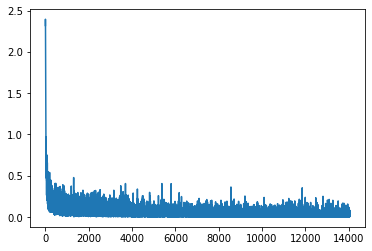

In [0]:
plt.plot(losses)

In [0]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)


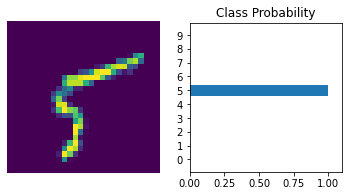

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[59]


img = img.resize_(1,1,28,28)



with torch.no_grad():
    logps = net(img)
    
ps = torch.exp(logps)

# Plotting the image and probabilities
view_classify(img.cpu(), ps.cpu())